In [1]:
# Import libraries
# Presente par Ahmed Mohamed, Sofiene Fehri, Abdessalam Nahnah, Mouard Benchickh

import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from skimage.feature import hog
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.decomposition import PCA


%matplotlib inline
from google.colab import drive
from google.colab import files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def load_images(tlabels):
  train = np.load("/content/gdrive/My Drive/notebooks/train_images.npy", encoding = 'bytes')
  test = np.load("/content/gdrive/My Drive/notebooks/test_images.npy", encoding = 'bytes')
  train_labels = pd.read_csv("/content/gdrive/My Drive/notebooks/train_labels.csv")

  x_train = train[:,1]
  x_test = test[:,1]
  for i in range(len(x_train)):
    x_train[i] = (x_train[i] - np.min(x_train[i]))/(np.max(x_train[i] - np.min(x_train[i])))
  for i in range(len(x_test)):          
    x_test[i] = (x_test[i] - np.amin(x_test[i]))/(np.amax(x_test[i] - np.amin(x_test[i])))

  train_labs = pd.factorize(train_labels['Category'])
  train_lab = train_labs[0]

  x_train = np.array([np.array(x) for x in x_train])
  x_test = np.array([np.array(x) for x in x_test])

  x_train = x_train.reshape((10000,100,100))
  x_test = x_test.reshape((10000,100,100))

  lb = LabelBinarizer()
  y_train = lb.fit_transform(train_lab)
  x_train,y_train = shuffle(x_train,y_train, random_state = random.randint(1,21)*5)

  train_X = x_train[:8000]
  train_y = y_train[:8000]
  valid_X = x_train[8000:]
  valid_y = y_train[8000:]
  test_X = x_test

  print(train_X.shape,valid_X.shape,valid_y.shape)
  
  if tlabels:
    return train_X,train_y,valid_X,valid_y, test_X,train_labels
  
  return train_X,train_y,valid_X,valid_y, test_X


In [0]:
def denoise(noisy,s1,s2,s3,s4):
  se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (s1,s1))
  se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (s2,s2))
  se3 = cv2.getStructuringElement(cv2.MORPH_RECT, (s3,s3))
  se4 = cv2.getStructuringElement(cv2.MORPH_RECT, (s4,s4))
  mask = cv2.morphologyEx(noisy, cv2.MORPH_CLOSE, se1)
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se3)
  mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se4)

  out = (noisy * mask)/255
  return out


def horizontal_flip(image_array: np.ndarray):
  # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
  return image_array[:, ::-1]

def tf_resize_images(X_img_file_paths):
  X_data = []
  tf.reset_default_graph()
  X = tf.placeholder(tf.float32, (None, None, 1))
  tf_img = tf.image.resize_images(X, (100, 100), 
                                  tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      # Each image is resized individually as different image may be of different size.
      for index, file_path in tqdm(enumerate(X_img_file_paths),desc="resizing train"):
          img = X_img_file_paths[index]
          resized_img = sess.run(tf_img, feed_dict = {X: img})
          X_data.append(resized_img)

  X_data = np.array(X_data, dtype = np.float32) # Convert to numpy
  return X_data

def tf_rotate_images(X_img_file_paths):
  X_data = []
  tf.reset_default_graph()
  X = tf.placeholder(tf.float32, (None, None, 1))
  degrees = tf.random_uniform([], -25, 25)
  tf_img = tf.contrib.image.rotate(X, degrees, interpolation='BILINEAR')

  tf_img = tf.image.resize_images(X, (100, 100), 
                                  tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      # Each image is resized individually as different image may be of different size.
      for index, file_path in tqdm(enumerate(X_img_file_paths),desc="rotating train"):
          img = X_img_file_paths[index]
          resized_img = sess.run(tf_img, feed_dict = {X: img})
          X_data.append(resized_img)

  X_data = np.array(X_data, dtype = np.float32) # Convert to numpy
  return X_data

def images_preprocessing(images):
      list_hog_fd = []
      for feature in tqdm(images):
              fd = hog(feature, orientations=9, pixels_per_cell=(50, 50), cells_per_block=(1, 1))
              list_hog_fd.append(fd)
      return np.array(list_hog_fd, 'float64')

In [0]:
def data_augmentation(X, y = None, denoise_mask1 = False, denoise_mask2 = False, rand_rotate=False, rand_resize=False, horiz_flip = False):
  
  if denoise_mask1 :
    tr1_X = X.copy()
    for i in tqdm(range(len(X)),desc='denoising train 1'):
      tr1_X[i] = denoise(tr1_X[i],7,5,5,1)
    X = np.row_stack((X,tr1_X))
    if y.any():
      y = np.row_stack((y,y))
                           
  if denoise_mask2 :
    tr2_X = X.copy()
    for i in tqdm(range(len(X)),desc='denoising train 2'):
      tr2_X[i] = denoise(tr2_X[i],6,4,4,1)
    X = np.row_stack((X,tr2_X))
    if y.any():
      y = np.row_stack((y,y))
 
  if horiz_flip : 
    tr_hor_flip = horizontal_flip(X)
    X = np.row_stack((X,tr_hor_flip))
    y = np.row_stack((y,y))
   
  X = reshape_dataset(X)
  
  if rand_rotate : 
    tr_rotate = tf_rotate_images(X.reshape(-1, 100, 100, 1))
    X = np.row_stack((X,tr_rotate))
    y = np.row_stack((y,y))

  if rand_resize:
    tr_resize = tf_resize_images(X.reshape(-1, 100, 100, 1))
    X = np.row_stack((X,tr_resize))
    y = np.row_stack((y,y))

  return shuffle(X,y, random_state = random.randint(1,21)*5)

In [0]:
def reshape_dataset(X):
  # Reshape training , validation and testing image
  X = X.reshape(-1, 100, 100, 1)
  return X

In [0]:
def compatible_convolutional_noise_shape(Y):
    noiseshape = tf.shape(Y)
    noiseshape = noiseshape * tf.constant([1,0,0,1]) + tf.constant([0,1,1,0])
    return noiseshape

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    training = tf.placeholder(tf.bool)
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.layers.batch_normalization(x)
    x = tf.nn.bias_add(x, b)

    return tf.nn.relu6(x) 

def avgpool2d(x, k=2):
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')
  
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')
  
def batchnorm(Ylogits, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    print(Ylogits)
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_everages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_everages

In [0]:
def initialize_filters(filter_sizes,num_filters,final_size,init):
  initializer = None
  if 'xavier' in init:
    initial=tf.contrib.layers.xavier_initializer()
  else:
    initial=tf.contrib.layers.variance_scaling_initializer()

  weights = {'wc'+str(i+1): tf.get_variable('W'+str(i), shape=(filter_sizes[i][0],filter_sizes[i][1],num_filters[i],num_filters[i+1]), initializer = initial)
             for i in range(len(num_filters)-1)}
  biases = {'bc'+str(i+1):tf.get_variable('B'+str(i), shape=(num_filters[i+1]), initializer=initial) for i in range(len(num_filters)-1)}

  weights['wd1'] = tf.get_variable('W'+str(len(num_filters)), shape=(final_size*final_size*num_filters[len(num_filters)-1],num_filters[len(num_filters)-1]), initializer = initial)
  weights['out'] = tf.get_variable('W'+str(len(num_filters)+1), shape=(num_filters[len(num_filters)-1],n_classes), initializer = initial)
  biases['bd1'] = tf.get_variable('B'+str(len(num_filters)), shape=(num_filters[len(num_filters)-1]), initializer = initial)
  biases['out'] = tf.get_variable('B'+str(len(num_filters)+1), shape=(n_classes), initializer = initial)
  
  return weights,biases
                          

In [0]:
def cnn(x,weights,biases,strides,dropout,drop = 0):
  conv = None
  for i in range(len(weights)-2):
    conv = conv2d(x, weights['wc'+str(i+1)], biases['bc'+str(i+1)])
    print(conv)
    conv = maxpool2d(conv, k=strides)
    print(conv)
    x = conv
  # Reshape conv2 output to fit fully connected layer input
  fc1 = tf.reshape(conv, [-1, weights['wd1'].get_shape().as_list()[0]])
  print(fc1)

  fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
  fc1 = tf.nn.relu(fc1)
  # Output, class prediction
  # finally we multiply the fully connected layer with the weights and add a bias term. 
  out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
  print(out)

  if drop:
    drop = tf.layers.dropout(inputs=out, rate=drop)
    print(drop)
    return drop

  return out

In [0]:
def run_session():
  with tf.Session() as sess:
    init=tf.global_variables_initializer()
    sess.run(init) 
    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []
    train_writer = tf.summary.FileWriter(DIR + '/train',sess.graph)
    test_writer = tf.summary.FileWriter(DIR + '/test')
    for i in range(training_iters):
  #         if i%20 == 0:
  #               train_X, train_y = shuffle(train_X,train_y, random_state = i)
        for batch in tqdm(range(len(train_X)//batch_size)):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]   
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            summary, loss, acc = sess.run([merged,cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
            train_writer.add_summary(summary, i)


        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")
        summary, valid_acc = sess.run([merged,accuracy], feed_dict={x:valid_X, y:valid_y})
        test_writer.add_summary(summary, i)

        train_loss.append(loss)
        valid_loss.append(valid_loss)
        train_accuracy.append(acc)
        valid_accuracy.append(valid_acc)
        print("Validation Accuracy:","{:.5f}".format(valid_acc))
    predict = sess.run([predict], feed_dict={x: test_X})
    summary_writer.close()

In [10]:
train_X,train_y,valid_X,valid_y, test_X = load_images(False)
train_X = reshape_dataset(train_X)
valid_X = reshape_dataset(valid_X)
test_X = reshape_dataset(test_X)

training_iters = 400 
learning_rate = 0.001 
batch_size = 128

# Kaggle data input (img shape: 100*100)
n_input = 100

# Kaggle total classes (31 classes)
n_classes = 31

#both placeholders are of type float
x = tf.placeholder("float", [None, 100,100,1])
y = tf.placeholder("float", [None, n_classes])

weights,biases = initialize_filters([(8,8),(8,8),(8,8),(4,4),(4,4),(2,2)],[1,8,16,32,64,128,256],2,'xavier')
pred = cnn(x,weights,biases,2,True,0.4)

with tf.name_scope("cost"):
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))
  tf.summary.scalar('loss', cost)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
predict = tf.argmax(pred, 1)

#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

with tf.name_scope("accuracy"):
#calculate accuracy across all the given images and average them out. 
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  tf.summary.scalar('accuracy', accuracy)
  
# Initializing the variables
sess = tf.Session()
DIR = "/content/drive/My Drive/Colab Notebooks/"
merged = tf.summary.merge_all()

run_session()

(8000, 100, 100) (2000, 100, 100) (2000, 31)
Tensor("Relu6:0", shape=(?, 100, 100, 8), dtype=float32)
Tensor("MaxPool:0", shape=(?, 50, 50, 8), dtype=float32)
Tensor("Relu6_1:0", shape=(?, 50, 50, 16), dtype=float32)
Tensor("MaxPool_1:0", shape=(?, 25, 25, 16), dtype=float32)
Tensor("Relu6_2:0", shape=(?, 25, 25, 32), dtype=float32)
Tensor("MaxPool_2:0", shape=(?, 13, 13, 32), dtype=float32)
Tensor("Relu6_3:0", shape=(?, 13, 13, 64), dtype=float32)
Tensor("MaxPool_3:0", shape=(?, 7, 7, 64), dtype=float32)
Tensor("Relu6_4:0", shape=(?, 7, 7, 128), dtype=float32)
Tensor("MaxPool_4:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("Relu6_5:0", shape=(?, 4, 4, 256), dtype=float32)
Tensor("MaxPool_5:0", shape=(?, 2, 2, 256), dtype=float32)
Tensor("Reshape:0", shape=(?, 1024), dtype=float32)
Tensor("Add_1:0", shape=(?, 31), dtype=float32)
Tensor("dropout/Identity:0", shape=(?, 31), dtype=float32)


100%|██████████| 125/125 [00:07<00:00, 21.64it/s]


Iter 0, Loss= 3.348546, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 2/125 [00:00<00:06, 19.61it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.18it/s]


Iter 1, Loss= 3.345601, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 22.01it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.34it/s]


Iter 2, Loss= 3.343091, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.86it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.26it/s]


Iter 3, Loss= 3.338244, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 22.03it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.11it/s]


Iter 4, Loss= 3.333791, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.94it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 20.95it/s]


Iter 5, Loss= 3.332219, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.72it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.14it/s]


Iter 6, Loss= 3.336587, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.55it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 20.89it/s]


Iter 7, Loss= 3.331732, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.49it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.01it/s]


Iter 8, Loss= 3.331067, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.19it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 20.94it/s]


Iter 9, Loss= 3.330878, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.78it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.40it/s]


Iter 10, Loss= 3.330750, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.84it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.28it/s]


Iter 11, Loss= 3.330640, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.80it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.54it/s]


Iter 12, Loss= 3.334883, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.44it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 20.70it/s]


Iter 13, Loss= 3.328991, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.47it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.03it/s]


Iter 14, Loss= 3.330904, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.56it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.32it/s]


Iter 15, Loss= 3.332753, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.31it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.21it/s]


Iter 16, Loss= 3.325380, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.56it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.10it/s]


Iter 17, Loss= 3.331449, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.07it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.07it/s]


Iter 18, Loss= 3.330465, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.22it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.20it/s]


Iter 19, Loss= 3.331502, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.20it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.21it/s]


Iter 20, Loss= 3.326369, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.45it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.54it/s]


Iter 21, Loss= 3.332001, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 22.05it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.44it/s]


Iter 22, Loss= 3.326640, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 2/125 [00:00<00:06, 19.40it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.48it/s]


Iter 23, Loss= 3.329930, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.20it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.20it/s]


Iter 24, Loss= 3.331755, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 22.39it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.10it/s]


Iter 25, Loss= 3.327057, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 20.87it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.21it/s]


Iter 26, Loss= 3.331279, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.65it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.23it/s]


Iter 27, Loss= 3.330513, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.48it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.30it/s]


Iter 28, Loss= 3.330246, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.34it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.13it/s]


Iter 29, Loss= 3.332100, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.44it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 20.96it/s]


Iter 30, Loss= 3.331630, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.27it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.24it/s]


Iter 31, Loss= 3.333010, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.60it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.27it/s]


Iter 32, Loss= 3.332501, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.56it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.22it/s]


Iter 33, Loss= 3.332068, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.12it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.25it/s]


Iter 34, Loss= 3.332268, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.23it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.09it/s]


Iter 35, Loss= 3.331913, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.84it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.40it/s]


Iter 36, Loss= 3.333271, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 22.07it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.03it/s]


Iter 37, Loss= 3.331804, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.34it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.11it/s]


Iter 38, Loss= 3.332783, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.60it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.29it/s]


Iter 39, Loss= 3.331092, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 22.05it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.27it/s]


Iter 40, Loss= 3.333204, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.49it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.24it/s]


Iter 41, Loss= 3.333224, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.69it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.22it/s]


Iter 42, Loss= 3.333557, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.39it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.00it/s]


Iter 43, Loss= 3.332692, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.30it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.09it/s]


Iter 44, Loss= 3.332510, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.36it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.12it/s]


Iter 45, Loss= 3.332468, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 22.04it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.28it/s]


Iter 46, Loss= 3.332485, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.68it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.36it/s]


Iter 47, Loss= 3.332351, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.82it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.18it/s]


Iter 48, Loss= 3.332529, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.78it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.34it/s]


Iter 49, Loss= 3.332861, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.22it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.33it/s]


Iter 50, Loss= 3.331651, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 22.23it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.32it/s]


Iter 51, Loss= 3.332963, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 20.96it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.48it/s]


Iter 52, Loss= 3.332659, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.62it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.21it/s]


Iter 53, Loss= 3.332423, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:06, 20.03it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.43it/s]


Iter 54, Loss= 3.332478, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.68it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.12it/s]


Iter 55, Loss= 3.332401, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.65it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 20.92it/s]


Iter 56, Loss= 3.332309, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 20.99it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 20.89it/s]


Iter 57, Loss= 3.332432, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.90it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.29it/s]


Iter 58, Loss= 3.332370, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.21it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.33it/s]


Iter 59, Loss= 3.332281, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.81it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.00it/s]


Iter 60, Loss= 3.332414, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.14it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.31it/s]


Iter 61, Loss= 3.332325, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.86it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.20it/s]


Iter 62, Loss= 3.332289, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.02it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.19it/s]


Iter 63, Loss= 3.332317, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 20.87it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.07it/s]


Iter 64, Loss= 3.332422, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.34it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.22it/s]


Iter 65, Loss= 3.332275, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.65it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.22it/s]


Iter 66, Loss= 3.331126, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.36it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 20.94it/s]


Iter 67, Loss= 3.332619, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.67it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.55it/s]


Iter 68, Loss= 3.332315, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.36it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.31it/s]


Iter 69, Loss= 3.332159, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.63it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.22it/s]


Iter 70, Loss= 3.332285, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 20.94it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.09it/s]


Iter 71, Loss= 3.332252, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.47it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.45it/s]


Iter 72, Loss= 3.332215, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.39it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.35it/s]


Iter 73, Loss= 3.332354, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.32it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.33it/s]


Iter 74, Loss= 3.332171, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.99it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.22it/s]


Iter 75, Loss= 3.331018, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.61it/s]

Validation Accuracy: 0.06050


100%|██████████| 125/125 [00:05<00:00, 21.15it/s]


Iter 76, Loss= 3.332735, Training Accuracy= 0.09375
Optimization Finished!


  2%|▏         | 3/125 [00:00<00:05, 21.49it/s]

Validation Accuracy: 0.06050


 48%|████▊     | 60/125 [00:02<00:03, 21.19it/s]


KeyboardInterrupt: ignored

In [0]:
den_tr_X, den_tr_y = data_augmentation(train_X.reshape((8000,100,100)),train_y,True)

In [0]:
plt.figure(figsize=(7,7))
plt.imshow(train_X[0].reshape((100,100)),cmap='binary_r')

In [0]:
plt.figure(figsize=(7,7))
plt.imshow(den_tr_X[8000].reshape((100,100)),cmap='binary_r')

In [0]:
|def cross_validate(session, split_size=5):
  results = []
  kf = KFold(n_splits=split_size)
  for train_idx, val_idx in kf.split(train_X, train_y):
    x_train = train_X[train_idx]
    y_train = train_y[train_idx]
    val_x = train_X[val_idx]
    val_y = train_y[val_idx]
    run_train(session, train_X, train_y)
    results.append(session.run(accuracy, feed_dict={x: val_x, y: val_y}))
  return results

In [0]:
import csv
myFile = open('submission-final1.csv', 'w')  
with myFile:  
    writer = csv.writer(myFile)
    writer.writerow(['Id','Category'])
    for i in range(len(train_labs[0])):
        writer.writerow([i,train_labs[1][predict[0][i]]])

In [11]:
from sklearn.svm import LinearSVC

train_X,train_y,valid_X,valid_y, test_X,train_labels = load_images(True)
pca = PCA(n_components=2,whiten=True)
train_X = pca.fit_transform(train_X.reshape((8000,10000)))
valid_X = pca.transform(valid_X.reshape((2000,10000)))
svc = LinearSVC(random_state=0, tol=1e-5)
svc.fit(train_X.reshape(8000,2), train_labels['Category'][:8000])
z = svc.predict(valid_X.reshape((2000,2)))
f1 = z[z == train_labels['Category'][8000:]]
len(f1)/len(train_labels['Category'][8000:])

(8000, 100, 100) (2000, 100, 100) (2000, 31)


0.055

No handles with labels found to put in legend.


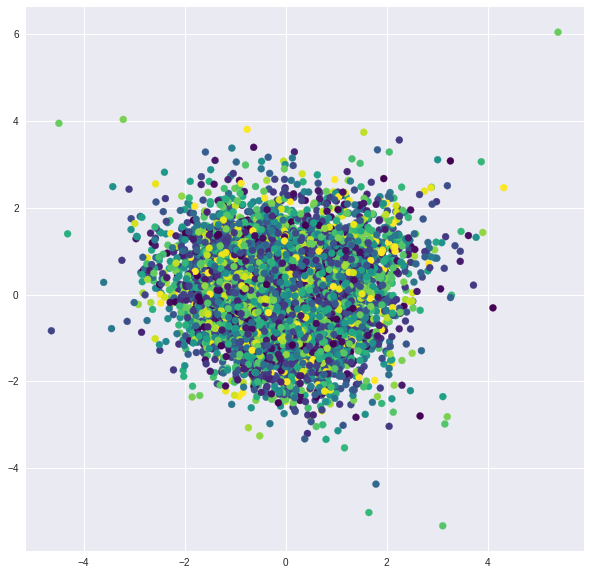

In [12]:
y = pd.factorize(train_labels.iloc[:8000,1])[0].astype(np.uint16)
plt.figure(figsize=(10,10))
plt.scatter(train_X[:,0],train_X[:,1],c=y,cmap='viridis')
plt.legend()

In [17]:
np.min(y)

0